In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid

In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [3]:
n_bins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [4]:
n_external = 3000
external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)

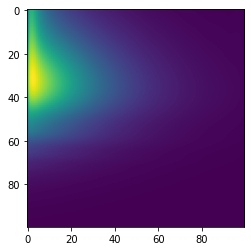

In [5]:
Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_quad_nbins_%d.npy'%(zmin, zmax, n_bins)
I_kappa = np.load(Ik_fname)
plt.imshow(I_kappa)

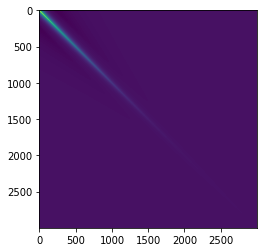

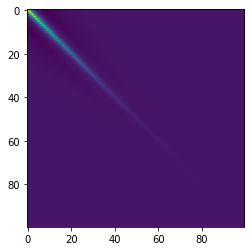

In [6]:
#get <II>
I_I_unbinned = np.load('/scratch/users/delon/LIMxCMBL/I_auto/'+
                          'I_auto_nbins_%d_zmin_%.1f_zmax_%.1f.npy'%(n_external, 
                                                                     zmin, 
                                                                     zmax))

plt.imshow(I_I_unbinned[0])
plt.show()

I_I = np.zeros((100, n_bins, n_bins), dtype=np.float64)
for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
    for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
        idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
        I_I[:,i,j] = (np.sum(I_I_unbinned[:,
                                          idx1[0]:idx1[-1]+1,
                                          idx2[0]:idx2[-1]+1], 
                             axis=(1, 2)) / len(idx1) / len(idx2))
plt.imshow(I_I[0])

[]

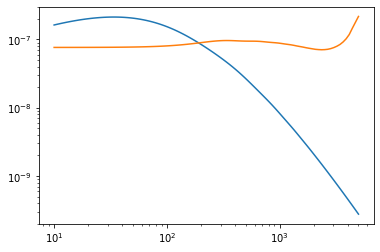

In [7]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [8]:
from tqdm import tqdm

In [9]:
SNR2_per_mode_full = {}
SNR2_per_mode_noise_dom = {}

# full cov no filtering SNR per mode

In [10]:
from LIMxCMBL.noise import f_eIeI
cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0)))
cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  I_I)
cov += np.einsum('lx ,l y->lxy', I_kappa, I_kappa)
cov = cov.astype(np.float64)

SNR2_per_mode_full[0.0] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, I_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_full[0.0][ell_idx] = np.dot(I_kappa[ell_idx], x)

# noise dom no filtering SNR per mode

In [11]:
from LIMxCMBL.noise import f_eIeI
cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0)))
cov = cov.astype(np.float64)

SNR2_per_mode_noise_dom[0.0] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, I_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_noise_dom[0.0][ell_idx] = np.dot(I_kappa[ell_idx], x)

# SNR per mode with filtering

In [12]:

Lambda_idx = -1
#IHi (cov) IHi
#cov = 1/Nmodes ((HIHI + eHIeHI)(KK + N0) + HIk HIk)

for Lambda in tqdm(Lambdas):
    Lambda_idx += 1
    
    #IHi_kappa##########################################
    ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, n_bins)
    ILo_kappa = np.load(ILo_kappa_fname)
    IHi_kappa = I_kappa - ILo_kappa
    ####################################################
    #IHi_IHi############################################
    ## cross terms in IHi IHi
    cross_fname = '/scratch/users/delon/LIMxCMBL/I_auto/I_ILo_'
    cross_fname += 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_n_chib_%d.npy'%(zmin, 
                                                                               zmax, 
                                                                               Lambda_idx, 
                                                                               n_external, 
                                                                               1024)

    cross_unbinned = np.load(cross_fname)
    cross = np.zeros_like(I_I)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
            cross[:,i,j] = (np.sum(cross_unbinned[:,idx1[0]:idx1[-1]+1,idx2[0]:idx2[-1]+1], 
                                    axis=(1, 2))/ len(idx1) / len(idx2))
            
    ##ILo ILo
    filtered_auto_fname = '/scratch/users/delon/LIMxCMBL/I_auto/ILo_ILo_'
    filtered_auto_fname += 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_n_chib_%d.npy'%(zmin, 
                                                                                       zmax, 
                                                                                       Lambda_idx, 
                                                                                       100, 
                                                                                       2048)
    ILoILo = np.load(filtered_auto_fname)
    
    ##IHi IHi
    #argh I need to sample ILoILo more densly I think
    IHiIHi = I_I  #- cross #+ ILoILo
    ####################################################
    #eHI eHI############################################
    eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/'
    eHIeHI_oup_fname += 'zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_log2_%d_nbins_%d.npy'%(zmin, 
                                                                                       zmax, 
                                                                                       Lambda_idx, 
                                                                                       13, 
                                                                                       n_bins)
    eHIeHI_binned = np.load(eHIeHI_oup_fname)
    ####################################################
    #full cov###########################################
    #l -> ells
    #x -> chi
    #y -> chi'
    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  IHiIHi)
    cov += np.einsum('lx ,l y->lxy', IHi_kappa, IHi_kappa)
    cov = cov.astype(np.float64)
    
    SNR2_per_mode_full[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode_full[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
    ####################################################
    #noise-dom cov######################################
    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov = cov.astype(np.float64)
    SNR2_per_mode_noise_dom[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode_noise_dom[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
    ####################################################

100%|██████████| 25/25 [03:12<00:00,  7.71s/it]


In [32]:
SNR2_per_mode_unbinned = {}
SNR2_per_mode_unbinned[0.0] = SNR2_per_mode_noise_dom[0.0]

Lambda_idx = -1
for Lambda in tqdm(Lambdas):
    Lambda_idx += 1
    try:
        computed_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_%.5f_zmax_%.5f_Lambda_idx_%d_log2_%d'%(zmin, zmax, Lambda_idx, 13)
        oup1_fname = computed_oup_fname + '_full.npy'
        SNR2_per_mode_unbinned[Lambda] = np.load(oup1_fname)/Pei
    except:
        print('skipping', Lambda_idx, Lambda)

100%|██████████| 25/25 [00:00<00:00, 2515.29it/s]

skipping 16 0.004641588833612777
skipping 17 0.006812920690579608
skipping 18 0.01
skipping 19 0.01467799267622069
skipping 20 0.021544346900318822
skipping 21 0.03162277660168379
skipping 22 0.046415888336127774
skipping 23 0.06812920690579609
skipping 24 0.1


In [33]:
Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

In [34]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode_full)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

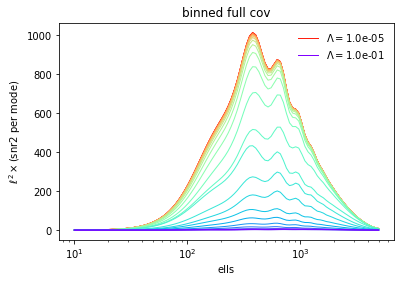

In [35]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.title('binned full cov')
plt.ylabel(r'$\ell^2\times$(snr2 per mode)')
plt.legend(frameon=False)

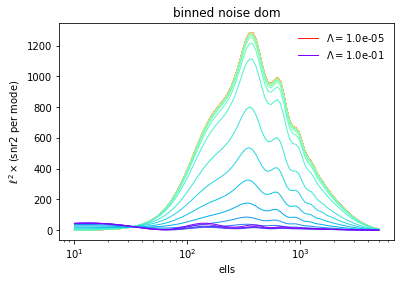

In [36]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_noise_dom[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.title('binned noise dom')
plt.ylabel(r'$\ell^2\times$(snr2 per mode)')
plt.legend(frameon=False)

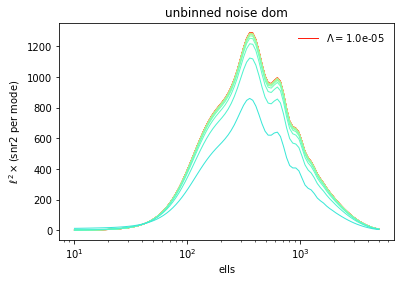

In [37]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode_unbinned.keys():
    label = None
    if(Lambda == 1e-5 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_unbinned[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.title('unbinned noise dom')
plt.ylabel(r'$\ell^2\times$(snr2 per mode)')
plt.legend(frameon=False)

In [38]:
#old calculation
SNR2_per_Omega_unbinned = np.zeros(len(SNR2_per_mode_unbinned), 
                                       dtype = np.float64)

for Lambda_idx in range(len(SNR2_per_mode_unbinned)):
    Lambda = Lambdas[Lambda_idx]    
    SNR2_per_Omega_unbinned[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode_unbinned[Lambda] 
                                                    * ells ** 2 
                                                    / 2 / np.pi)

In [39]:
#new calculation
SNR2_per_Omega_full      = np.zeros(len(Lambdas))
SNR2_per_Omega_noise_dom = np.zeros(len(Lambdas))

for Lambda_idx,Lambda in enumerate(Lambdas):
    SNR2_per_Omega_noise_dom[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                     y = SNR2_per_mode_noise_dom[Lambda] 
                                                     * ells ** 2 
                                                     / 2 / np.pi)
    
    SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                y = SNR2_per_mode_full[Lambda] 
                                                * ells ** 2 
                                                / 2 / np.pi)

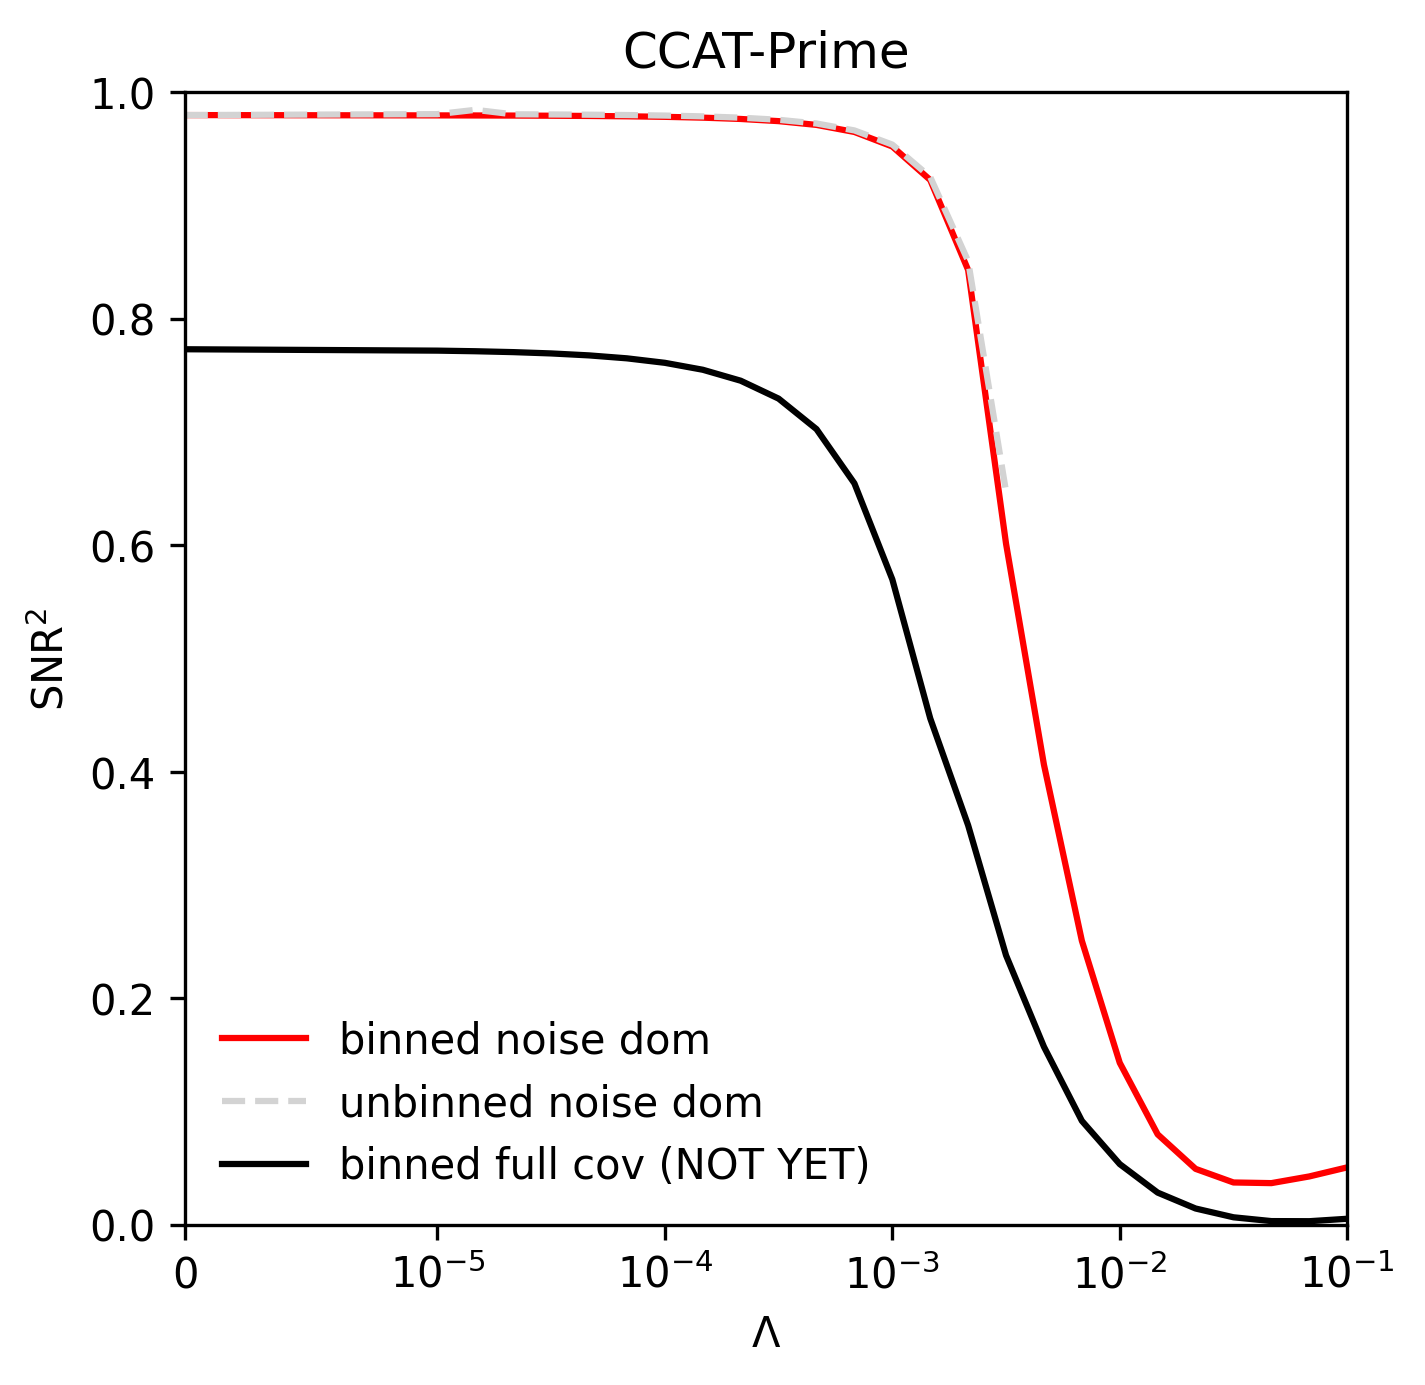

In [45]:
plt.figure(figsize = (5,5) ,dpi = 300, facecolor = 'w')





plt.plot(Lambdas, (SNR2_per_Omega_noise_dom * Omega_field), 
         'r',
        label='binned noise dom')

plt.plot(SNR2_per_mode_unbinned.keys(), (SNR2_per_Omega_unbinned * Omega_field), 
         'lightgrey',
         ls='--',
        label='unbinned noise dom')

plt.plot(Lambdas, (SNR2_per_Omega_full * Omega_field), 
         'k',
        label='binned full cov (NOT YET)')



plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e-1)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'${\sf SNR}^2$')
plt.title('CCAT-Prime')

plt.legend(frameon=False)